Name: Vedant Modi
<br>
Czerniak,Jacek. (2009). Acute Inflammations. UCI Machine Learning Repository. https://doi.org/10.24432/C5V59S.

## 1. Decision Trees as Interpretable Models

Import packages

In [24]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_text
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import RidgeCV
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

### (a) Obtain Data

Get the Accute Inamations Data Set

In [2]:
columns = ['Temperature', "OccurrenceNausea", "LumbarPain", "UrinePushing", "MicturitionPains", "Burning", "Inflammation", "Nephritis"]
data = pd.read_csv(f"../data/diagnosis.data", sep='\t', encoding='utf-16')
data.columns = columns
for column in columns:
    data[column] = data[column].replace({'yes': 1, 'no': 0})
    
data

,Temperature,OccurrenceNausea,LumbarPain,UrinePushing,MicturitionPains,Burning,Inflammation,Nephritis
0,35.9,0,0,1,1,1,1,0
1,35.9,0,1,0,0,0,0,0
2,36.0,0,0,1,1,1,1,0
3,36.0,0,1,0,0,0,0,0
4,36.0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
114,41.4,0,1,1,0,1,0,1
115,41.5,0,0,0,0,0,0,0
116,41.5,1,1,0,1,0,0,1
117,41.5,0,1,1,0,1,0,1


### (b) Build a decision tree

In [3]:
X = data[['Temperature', 'OccurrenceNausea', 'LumbarPain', 'UrinePushing', 'MicturitionPains', 'Burning']]
y = data[['Inflammation', 'Nephritis']]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [6]:
decision_tree = DecisionTreeClassifier(random_state=42)
multi_output_tree = MultiOutputClassifier(decision_tree)
multi_output_tree.fit(X_train, y_train)

MultiOutputClassifier(estimator=DecisionTreeClassifier(random_state=42))

In [7]:
y_pred = multi_output_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for both targets:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy for both targets: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         7

   micro avg       1.00      1.00      1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19
 samples avg       0.67      0.67      0.67        19



/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### (c) Convert the decision rules

In [8]:
def decision_tree_to_rules(tree, feature_names, class_names):
    tree_rules = []

    def recurse(node, rule, depth=0):
        if tree.tree_.feature[node] != -2:  # If not a leaf node
            feature = feature_names[tree.tree_.feature[node]]
            threshold = tree.tree_.threshold[node]
            if depth == 0:
                rule = f'IF {feature} <= {threshold}'
            else:
                rule += f' AND {feature} <= {threshold}'
            recurse(tree.tree_.children_left[node], rule, depth + 1)
            rule = rule.rsplit(' AND', 1)[0]  # Removing the last condition for right branch
            rule += f' AND {feature} > {threshold}'
            recurse(tree.tree_.children_right[node], rule, depth + 1)
        else:  # If a leaf node
            class_idx = tree.tree_.value[node].argmax()
            class_name = class_names[class_idx]
            rule += f' THEN Class: {class_name}'
            tree_rules.append(rule)

    recurse(0, "")
    return tree_rules

rules = decision_tree_to_rules(multi_output_tree.estimators_[0], X.columns, ['Inflammation of urinary bladder', 'Nephritis of renal pelvis origin'])

# Print the rules
for i, rule in enumerate(rules):
    print(f"Rule {i + 1}: {rule}")


Rule 1: IF MicturitionPains <= 0.5 AND LumbarPain <= 0.5 AND UrinePushing <= 0.5 THEN Class: Inflammation of urinary bladder
Rule 2: IF MicturitionPains <= 0.5 AND LumbarPain <= 0.5 AND UrinePushing > 0.5 THEN Class: Nephritis of renal pelvis origin
Rule 3: IF MicturitionPains <= 0.5 AND LumbarPain > 0.5 THEN Class: Inflammation of urinary bladder
Rule 4: IF MicturitionPains <= 0.5 AND MicturitionPains > 0.5 AND UrinePushing <= 0.5 THEN Class: Inflammation of urinary bladder
Rule 5: IF MicturitionPains <= 0.5 AND MicturitionPains > 0.5 AND UrinePushing > 0.5 THEN Class: Nephritis of renal pelvis origin


Initial Accuracy: 1.0


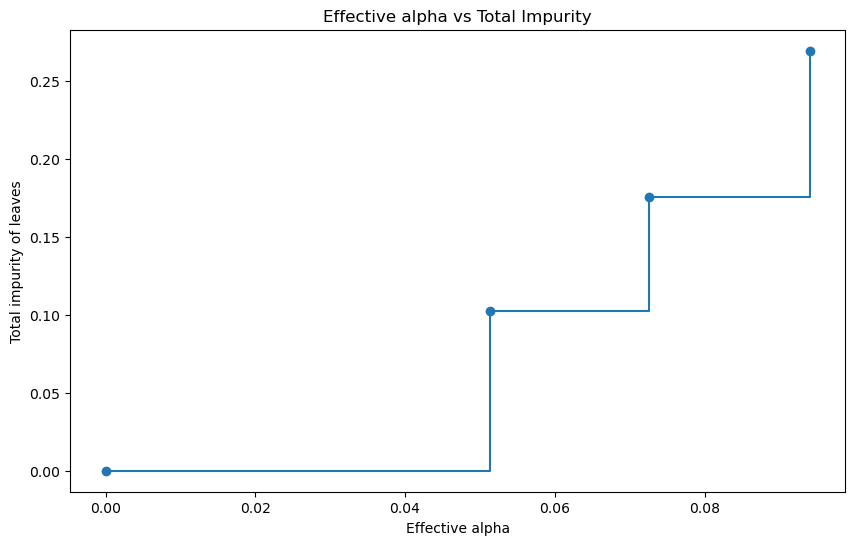

Best alpha: 0.2246769709828884
Pruned Accuracy: 0.20833333333333334
The pruned decision tree is empty.


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

initial_tree = DecisionTreeClassifier(random_state=42)
initial_tree.fit(X_train, y_train)

initial_accuracy = accuracy_score(y_test, initial_tree.predict(X_test))
print("Initial Accuracy:", initial_accuracy)

# Finding optimal alpha
path = initial_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plot the relationship between alpha and tree depth
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Effective alpha")
plt.ylabel("Total impurity of leaves")
plt.title("Effective alpha vs Total Impurity")
plt.show()

best_alpha = ccp_alphas[np.argmax(impurities)]
print("Best alpha:", best_alpha)

# Create a pruned decision tree with the best alpha value
pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
pruned_tree.fit(X_train, y_train)

# Calculate accuracy on the pruned tree
pruned_accuracy = accuracy_score(y_test, pruned_tree.predict(X_test))
print("Pruned Accuracy:", pruned_accuracy)

# Extract rules from the pruned decision tree if it's not empty
if pruned_tree.tree_.node_count > 1:
    rules = decision_tree_to_rules(pruned_tree, X.columns, ['Inflammation', 'Nephritis'])

    for i, rule in enumerate(rules):
        print(f"Rule {i + 1}: {rule}")
else:
    print("The pruned decision tree is empty.")

## 2. The LASSO and Boosting for Regression

In [10]:
columns1 = [", state", ", county", ", community", ", communityname", ", fold", ", population", ", householdsize", ", racepctblack", ", racePctWhite", ", racePctAsian", ", racePctHisp", ", agePct12t21", ", agePct12t29", ", agePct16t24", ", agePct65up", ", numbUrban", ", pctUrban", ", medIncome", ", pctWWage", ", pctWFarmSelf", ", pctWInvInc", ", pctWSocSec", ", pctWPubAsst", ", pctWRetire", ", medFamInc", ", perCapInc", ", whitePerCap", ", blackPerCap", ", indianPerCap", ", AsianPerCap", ", OtherPerCap", ", HispPerCap", ", NumUnderPov", ", PctPopUnderPov", ", PctLess9thGrade", ", PctNotHSGrad", ", PctBSorMore", ", PctUnemployed", ", PctEmploy", ", PctEmplManu", ", PctEmplProfServ", ", PctOccupManu", ", PctOccupMgmtProf", ", MalePctDivorce", ", MalePctNevMarr", ", FemalePctDiv", ", TotalPctDiv", ", PersPerFam", ", PctFam2Par", ", PctKids2Par", ", PctYoungKids2Par", ", PctTeen2Par", ", PctWorkMomYoungKids", ", PctWorkMom", ", NumIlleg", ", PctIlleg", ", NumImmig", ", PctImmigRecent", ", PctImmigRec5", ", PctImmigRec8", ", PctImmigRec10", ", PctRecentImmig", ", PctRecImmig5", ", PctRecImmig8", ", PctRecImmig10", ", PctSpeakEnglOnly", ", PctNotSpeakEnglWell", ", PctLargHouseFam", ", PctLargHouseOccup", ", PersPerOccupHous", ", PersPerOwnOccHous", ", PersPerRentOccHous", ", PctPersOwnOccup", ", PctPersDenseHous", ", PctHousLess3BR", ", MedNumBR", ", HousVacant", ", PctHousOccup", ", PctHousOwnOcc", ", PctVacantBoarded", ", PctVacMore6Mos", ", MedYrHousBuilt", ", PctHousNoPhone", ", PctWOFullPlumb", ", OwnOccLowQuart", ", OwnOccMedVal", ", OwnOccHiQuart", ", RentLowQ", ", RentMedian", ", RentHighQ", ", MedRent", ", MedRentPctHousInc", ", MedOwnCostPctInc", ", MedOwnCostPctIncNoMtg", ", NumInShelters", ", NumStreet", ", PctForeignBorn", ", PctBornSameState", ", PctSameHouse85", ", PctSameCity85", ", PctSameState85", ", LemasSwornFT", ", LemasSwFTPerPop", ", LemasSwFTFieldOps", ", LemasSwFTFieldPerPop", ", LemasTotalReq", ", LemasTotReqPerPop", ", PolicReqPerOffic", ", PolicPerPop", ", RacialMatchCommPol", ", PctPolicWhite", ", PctPolicBlack", ", PctPolicHisp", ", PctPolicAsian", ", PctPolicMinor", ", OfficAssgnDrugUnits", ", NumKindsDrugsSeiz", ", PolicAveOTWorked", ", LandArea", ", PopDens", ", PctUsePubTrans", ", PolicCars", ", PolicOperBudg", ", LemasPctPolicOnPatr", ", LemasGangUnitDeploy", ", LemasPctOfficDrugUn", ", PolicBudgPerPop", ", ViolentCrimesPerPop"]
columns = [item.replace(", ", "") for item in columns1]
columns

['state',
 'county',
 'community',
 'communityname',
 'fold',
 'population',
 'householdsize',
 'racepctblack',
 'racePctWhite',
 'racePctAsian',
 'racePctHisp',
 'agePct12t21',
 'agePct12t29',
 'agePct16t24',
 'agePct65up',
 'numbUrban',
 'pctUrban',
 'medIncome',
 'pctWWage',
 'pctWFarmSelf',
 'pctWInvInc',
 'pctWSocSec',
 'pctWPubAsst',
 'pctWRetire',
 'medFamInc',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'indianPerCap',
 'AsianPerCap',
 'OtherPerCap',
 'HispPerCap',
 'NumUnderPov',
 'PctPopUnderPov',
 'PctLess9thGrade',
 'PctNotHSGrad',
 'PctBSorMore',
 'PctUnemployed',
 'PctEmploy',
 'PctEmplManu',
 'PctEmplProfServ',
 'PctOccupManu',
 'PctOccupMgmtProf',
 'MalePctDivorce',
 'MalePctNevMarr',
 'FemalePctDiv',
 'TotalPctDiv',
 'PersPerFam',
 'PctFam2Par',
 'PctKids2Par',
 'PctYoungKids2Par',
 'PctTeen2Par',
 'PctWorkMomYoungKids',
 'PctWorkMom',
 'NumIlleg',
 'PctIlleg',
 'NumImmig',
 'PctImmigRecent',
 'PctImmigRec5',
 'PctImmigRec8',
 'PctImmigRec10',
 'PctRecentImmig',
 'P

### (a) Obtain Data

In [11]:
crimeDF = pd.read_csv(f"../data/communities.csv", sep=',', encoding='latin-1', na_values = ["?"])
crimeDF.columns = columns
crimeDF

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
1,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
2,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
3,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
4,6,NaN,NaN,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,...,0.01,0.58,0.10,NaN,NaN,NaN,NaN,0.00,NaN,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,12,NaN,NaN,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,NaN,NaN,NaN,NaN,0.00,NaN,0.09
1989,6,NaN,NaN,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,NaN,NaN,NaN,NaN,0.00,NaN,0.45
1990,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1991,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


In [12]:
crimeTrain = crimeDF.head(1495)
crimeTest = crimeDF.iloc[1495:]

In [13]:
crimeTrain

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
1,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
2,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
3,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
4,6,NaN,NaN,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,...,0.01,0.58,0.10,NaN,NaN,NaN,NaN,0.00,NaN,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,6,NaN,NaN,Orangecity,8,0.16,0.62,0.03,0.74,0.48,...,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1491,13,NaN,NaN,Waycrosscity,8,0.01,0.36,0.95,0.24,0.03,...,0.03,0.12,0.01,NaN,NaN,NaN,NaN,0.00,NaN,0.30
1492,39,85.0,49056.0,Mentorcity,8,0.06,0.53,0.01,0.98,0.05,...,0.08,0.15,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
1493,34,17.0,79610.0,WestNewYorktown,8,0.05,0.43,0.08,0.65,0.12,...,0.00,1.00,1.00,0.00,0.01,0.77,0.0,0.51,0.18,0.23


### (b) Missing values

In [14]:
columns_to_exclude = ['county', 'community', 'communityname', 'fold', 'state']
columns_to_fill = [col for col in crimeTrain.columns if col not in columns_to_exclude]

In [15]:
columns_to_fill_test = [col for col in crimeTest.columns if col not in columns_to_exclude]

In [16]:
crimeTrain[columns_to_fill] = crimeTrain[columns_to_fill].fillna(crimeTrain[columns_to_fill].median())
crimeTrain = crimeTrain.drop(columns=['county', 'community', 'communityname', 'fold', 'state'])
crimeTrain

/var/folders/n6/bxq_v0552b73sl2s_298p9k80000gn/T/ipykernel_9132/2680198975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimeTrain[columns_to_fill] = crimeTrain[columns_to_fill].fillna(crimeTrain[columns_to_fill].median())


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.07,0.03,0.76,0.5,0.00,0.15,0.67
1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.07,0.03,0.76,0.5,0.00,0.15,0.43
2,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,0.07,0.03,0.76,0.5,0.00,0.15,0.12
3,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.07,0.03,0.76,0.5,0.00,0.15,0.03
4,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,0.37,...,0.01,0.58,0.10,0.07,0.03,0.76,0.5,0.00,0.15,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1490,0.16,0.62,0.03,0.74,0.48,0.42,0.44,0.57,0.40,0.25,...,0.07,0.40,0.14,0.07,0.05,0.85,0.5,0.61,0.19,0.20
1491,0.01,0.36,0.95,0.24,0.03,0.01,0.44,0.42,0.27,0.63,...,0.03,0.12,0.01,0.07,0.03,0.76,0.5,0.00,0.15,0.30
1492,0.06,0.53,0.01,0.98,0.05,0.01,0.40,0.40,0.24,0.29,...,0.08,0.15,0.02,0.07,0.03,0.76,0.5,0.00,0.15,0.03
1493,0.05,0.43,0.08,0.65,0.12,1.00,0.37,0.52,0.33,0.44,...,0.00,1.00,1.00,0.00,0.01,0.77,0.0,0.51,0.18,0.23


In [17]:
crimeTest[columns_to_fill] = crimeTest[columns_to_fill].fillna(crimeTest[columns_to_fill].median())
crimeTest = crimeTest.drop(columns=['county', 'community', 'communityname', 'fold', 'state'])
crimeTest

/var/folders/n6/bxq_v0552b73sl2s_298p9k80000gn/T/ipykernel_9132/2587256823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crimeTest[columns_to_fill] = crimeTest[columns_to_fill].fillna(crimeTest[columns_to_fill].median())


,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
1495,0.00,0.55,0.13,0.78,0.15,0.36,0.48,0.53,0.30,0.10,...,0.01,0.18,0.02,0.08,0.03,0.73,0.5,0.00,0.165,0.11
1496,0.00,0.52,0.04,0.59,0.05,0.62,0.84,0.78,0.75,0.43,...,0.01,0.18,0.00,0.08,0.03,0.73,0.5,0.00,0.165,0.12
1497,0.04,0.51,0.07,0.92,0.09,0.03,0.38,0.47,0.27,0.35,...,0.06,0.13,0.16,0.08,0.03,0.73,0.5,0.00,0.165,0.06
1498,0.03,0.59,0.20,0.75,0.19,0.10,0.38,0.62,0.35,0.11,...,0.03,0.23,0.06,0.08,0.03,0.73,0.5,0.00,0.165,0.12
1499,0.01,0.48,0.02,0.77,0.84,0.05,0.37,0.26,0.20,0.50,...,0.01,0.23,0.05,0.08,0.03,0.73,0.5,0.00,0.165,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,0.01,0.40,0.10,0.87,0.12,0.16,0.43,0.51,0.35,0.30,...,0.01,0.28,0.05,0.08,0.03,0.73,0.5,0.00,0.165,0.09
1989,0.05,0.96,0.46,0.28,0.83,0.32,0.69,0.86,0.73,0.14,...,0.02,0.37,0.20,0.08,0.03,0.73,0.5,0.00,0.165,0.45
1990,0.16,0.37,0.25,0.69,0.04,0.25,0.35,0.50,0.31,0.54,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.280,0.23
1991,0.08,0.51,0.06,0.87,0.22,0.10,0.58,0.74,0.63,0.41,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.180,0.19


### (c) Plot a correlation matrix

In [18]:
correlation_matrix = crimeTrain.corr()

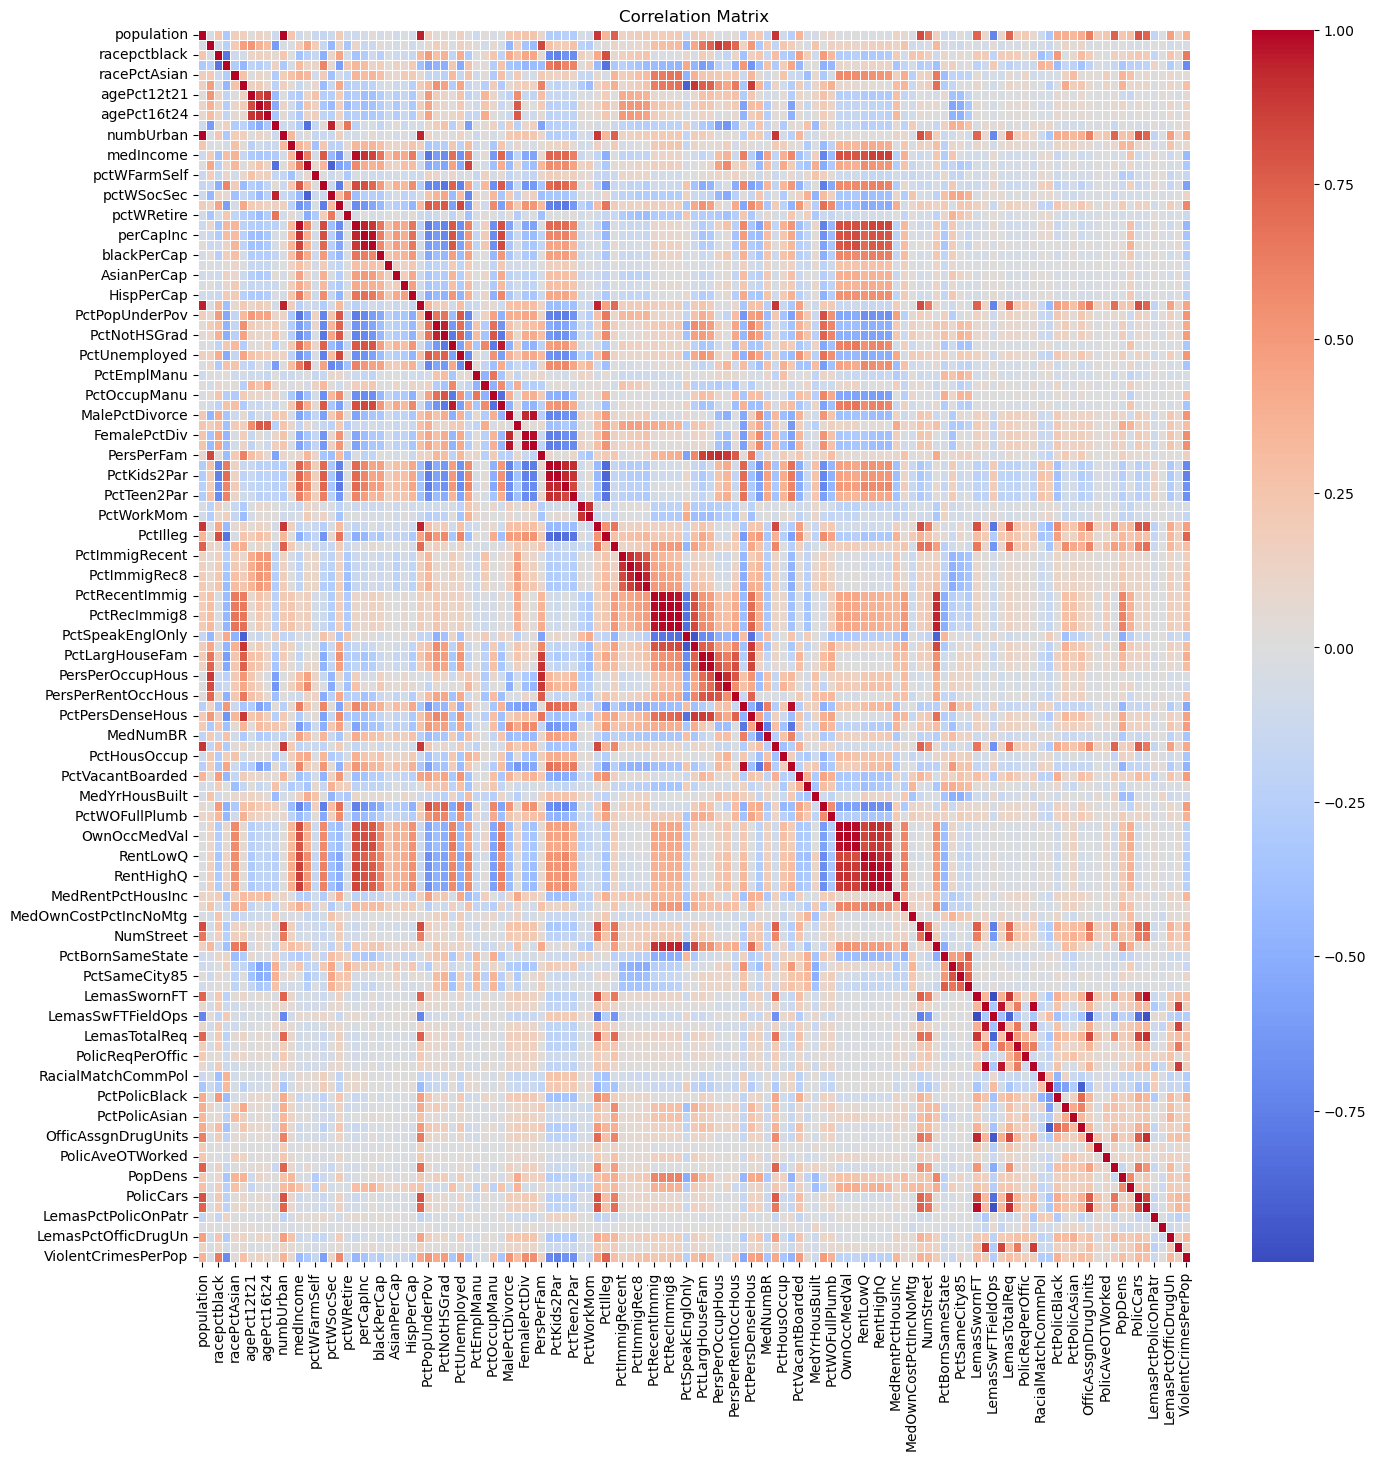

In [19]:
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=.5)
plt.title("Correlation Matrix")
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [20]:
cv_series = crimeTrain.std() / crimeTrain.mean()

In [21]:
cv_df = pd.DataFrame({'Column': cv_series.index, 'Coefficient of Variation (CV)': cv_series.values})
cv_df = cv_df.drop(cv_df.index[0])
display(cv_df)

,Column,Coefficient of Variation (CV)
1,householdsize,0.356092
2,racepctblack,1.428810
3,racePctWhite,0.330215
4,racePctAsian,1.358498
5,racePctHisp,1.613067
...,...,...
118,LemasPctPolicOnPatr,0.111931
119,LemasGangUnitDeploy,0.335104
120,LemasPctOfficDrugUn,2.558170
121,PolicBudgPerPop,0.408625


### (e) Scatter plots and box plots for highest CV features

In [26]:
cv_df_sorted = cv_df.sort_values(by='Coefficient of Variation (CV)', ascending=False)
features_n = math.floor(math.sqrt(128))
top_11 = cv_df_sorted.head(features_n)
top_11

,Column,Coefficient of Variation (CV)
108,PctPolicAsian,5.548343
90,NumStreet,4.292923
89,NumInShelters,3.474177
49,NumIlleg,3.061275
51,NumImmig,2.927967
120,LemasPctOfficDrugUn,2.558170
27,NumUnderPov,2.344769
96,LemasSwornFT,2.248578
10,numbUrban,2.041621
71,HousVacant,1.971525


In [27]:
features_n

11

In [28]:
column11 = top_11.Column.tolist()
column11

['PctPolicAsian',
 'NumStreet',
 'NumInShelters',
 'NumIlleg',
 'NumImmig',
 'LemasPctOfficDrugUn',
 'NumUnderPov',
 'LemasSwornFT',
 'numbUrban',
 'HousVacant',
 'LandArea']

In [29]:
crimeTrain11 = crimeTrain[column11]
crimeTrain11

,PctPolicAsian,NumStreet,NumInShelters,NumIlleg,NumImmig,LemasPctOfficDrugUn,NumUnderPov,LemasSwornFT,numbUrban,HousVacant,LandArea
0,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.02,0.02,0.02,0.02
1,0.00,0.00,0.00,0.01,0.00,0.00,0.01,0.02,0.00,0.01,0.01
2,0.00,0.00,0.00,0.03,0.02,0.00,0.01,0.02,0.06,0.01,0.02
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.02,0.01,0.04
4,0.00,0.00,0.00,0.00,0.04,0.00,0.01,0.02,0.04,0.02,0.01
...,...,...,...,...,...,...,...,...,...,...,...
1490,0.12,0.03,0.09,0.04,0.15,0.61,0.08,0.02,0.18,0.06,0.07
1491,0.00,0.00,0.00,0.03,0.00,0.00,0.04,0.02,0.00,0.05,0.03
1492,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.02,0.07,0.02,0.08
1493,0.00,0.00,0.00,0.04,0.15,0.51,0.06,0.01,0.06,0.07,0.00


/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


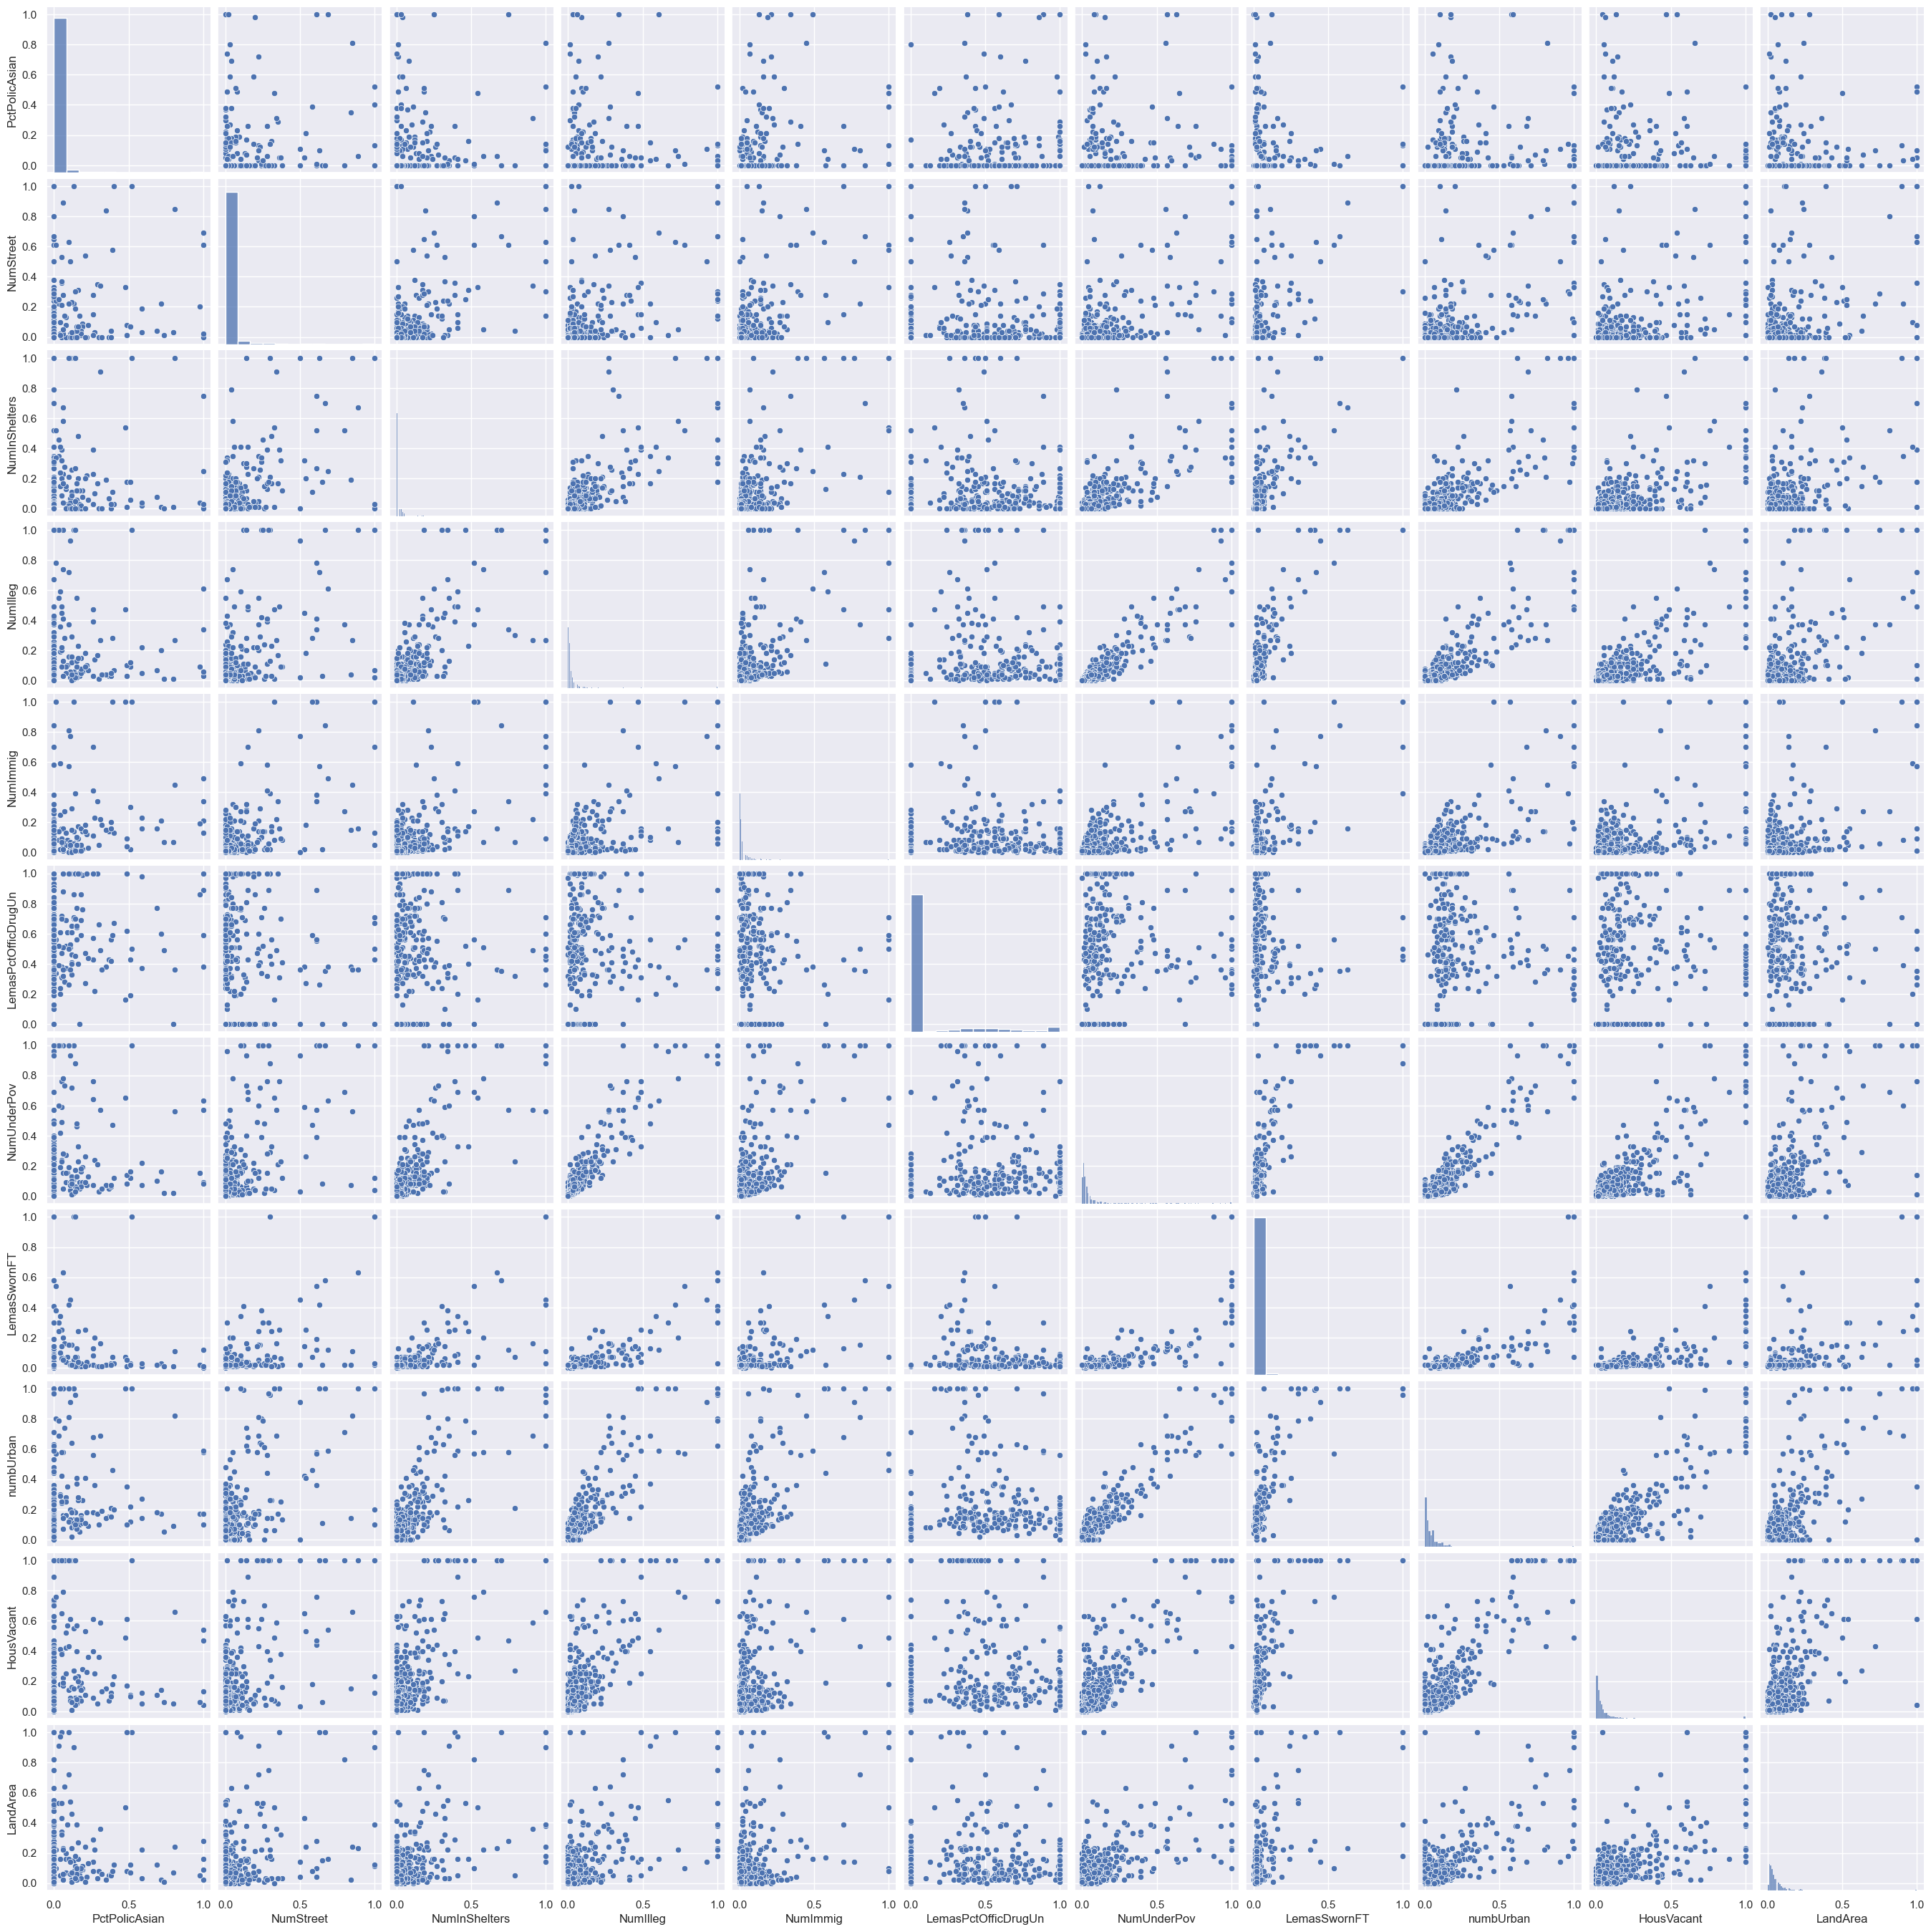

In [30]:
sns.set()
sns.pairplot(data = crimeTrain11)

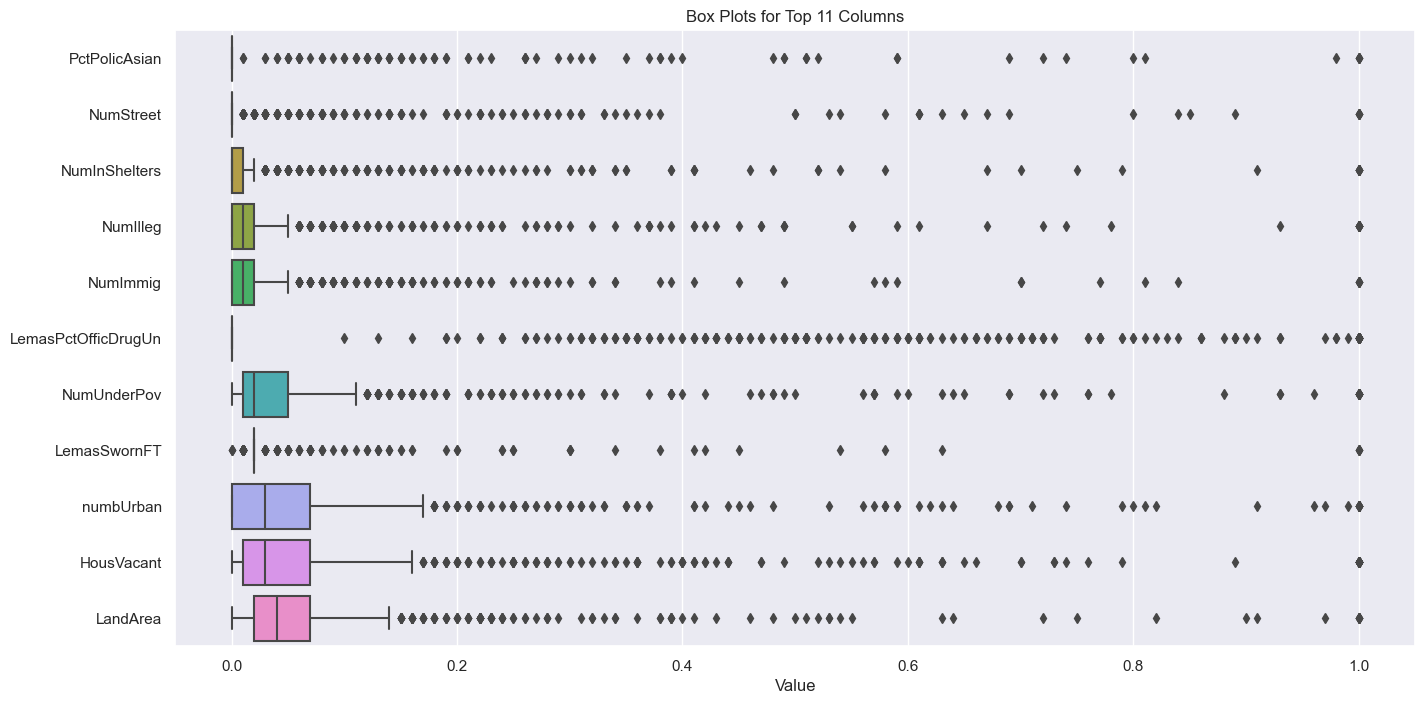

In [32]:
plt.figure(figsize=(16, 8))  
sns.boxplot(data=crimeTrain11, orient='h')  
plt.title("Box Plots for Top 11 Columns")
plt.xlabel("Value")
plt.show()

### (f) Fit a linear model

In [33]:
X_train = crimeTrain.drop('ViolentCrimesPerPop', axis=1)
y_train = crimeTrain['ViolentCrimesPerPop']

X_test = crimeTest.drop('ViolentCrimesPerPop', axis=1)
y_test = crimeTest['ViolentCrimesPerPop']

In [34]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [35]:
y_pred = model.predict(X_test)

In [36]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.01794662356961882


### (g) Fit a ridge regression model

In [37]:
alphas = []
for i in range(-10, 11, 1):
    alphas.append(10**i)
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000,
                100000000, 1000000000, 10000000000],
        store_cv_values=True)

In [38]:
best_alpha = ridge_cv.alpha_
y_pred = ridge_cv.predict(X_test)

In [39]:
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error with Ridge Regression: {mse}, using alpha value: {best_alpha}")

Test Mean Squared Error with Ridge Regression: 0.01764234390796357, using alpha value: 1.0


### (h) Fit a LASSO model

In [40]:
lasso_cv = LassoCV(alphas=alphas, cv=5)  # You can adjust the number of cross-validation folds (cv) as needed
lasso_cv.fit(X_train, y_train)

/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0958254626544974, tolerance: 0.006791095543478281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.875445493216535, tolerance: 0.006791095543478281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.02663849104126, tolerance: 0.006791095543478281
  model = cd_fast.enet_coordinate_descen

LassoCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000,
                100000000, 1000000000, 10000000000],
        cv=5)

In [41]:
best_alpha = lasso_cv.alpha_
y_pred = lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error with LASSO Regression: {mse} with best alpha: {best_alpha}")

Test Mean Squared Error with LASSO Regression: 0.017660319870405995 with best alpha: 0.0001


In [42]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.fit_transform(X_test)

In [43]:
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X_train_standardized, y_train)

/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14191952419045606, tolerance: 0.006791095543478281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.607715600130415, tolerance: 0.006791095543478281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/vedantmodi/anaconda3/envs/dsci552_hw0/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.683878031689119, tolerance: 0.006791095543478281
  model = cd_fast.enet_coordinate_desc

LassoCV(alphas=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000,
                100000000, 1000000000, 10000000000],
        cv=5)

In [44]:
best_alpha = lasso_cv.alpha_
y_pred = lasso_cv.predict(X_test_standardized)
mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error with Standardized LASSO Regression: {mse} with best alpha: {best_alpha}")

Test Mean Squared Error with Standardized LASSO Regression: 0.017850763402781366 with best alpha: 0.001


### (i) Fit a PCR model

In [45]:
pca = PCA()
lr = LinearRegression()
scores = []
components_range = range(1, X_train.shape[1] + 1)

for n_components in components_range:
    pca.n_components = n_components

    X_train_pca = pca.fit_transform(X_train)

    score = -cross_val_score(lr, X_train_pca, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    scores.append(score)

optimal_n_components = components_range[scores.index(min(scores))]

In [46]:
pca.n_components = optimal_n_components

X_train_pca = pca.fit_transform(X_train)

lr.fit(X_train_pca, y_train)

LinearRegression()

In [47]:
X_test_pca = pca.transform(X_test)

y_pred = lr.predict(X_test_pca)

mse = mean_squared_error(y_test, y_pred)
print(f"Test Mean Squared Error with PCR: {mse} with {optimal_n_components} components.")

Test Mean Squared Error with PCR: 0.01838900564398678 with 96 components.


### (j) Fit a boosting tree

In [48]:
min_error = float('inf')

for alpha in alphas:
    model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha = alpha, random_state = 42)
    score = cross_val_score(model, X_train, y_train, cv = KFold(5, shuffle = True, random_state = 42), scoring="neg_mean_squared_error")
    curr_error = sum(abs(score))/len(score)
    if curr_error < min_error:
        best_alpha = alpha
        min_error = curr_error
    
print(f"Validation Mean Squared Error with XGBoost: {min_error} with best alpha: {best_alpha}")

Validation Mean Squared Error with XGBoost: 0.02154849148091436 with best alpha: 1


In [49]:
model = xgb.XGBRegressor(objective='reg:squarederror', reg_alpha = best_alpha, random_state = 42)
model.fit(X_train, y_train)
test_mse = mean_squared_error(y_test, model.predict(X_test))

print(f"Test Mean Squared Error with XGBoost: {test_mse} with best alpha: {best_alpha}")

Test Mean Squared Error with XGBoost: 0.01879742174231053 with best alpha: 1
